# Drivable Area Detection

In this notebook we will trian a model to segment the drivable area of a road scene

# <a name="Data"></a>1. Data Collect, Visualization, Augmentation

This project will use the [BDD 100K Dataset](https://bdd-data.berkeley.edu/).<p>

It was downloaded from [this website](https://bdd-data.berkeley.edu/login.html) and then dumped into a pickle file.<p>-<p>

If you want to repeat the process, go to the [download page](https://bdd-data.berkeley.edu/portal.html#download) (once logged in) and click on the buttons **Images** and **Driverable Maps** under the BDD100K section.
It will download the necessary dataset. Then pick a subset of it.
Use Google Chrome and in case it doesn't work, hit the button again until it does.<p>-<p>

The data has already been downloaded and preprocessed to contains 2 categories for segmentation:
- drivable area (red)
- adjacent area (blue)
- background (green)

See preprocess_data.py for details on how to do this with the raw data.

The data has been placed in the following folder structure:

Data--<br>
&emsp;&emsp; train- <br>
&emsp;&emsp;&emsp;&emsp;  images <br>
&emsp;&emsp;&emsp;&emsp;  mask <br>
&emsp;&emsp; val- <br>
&emsp;&emsp;&emsp;&emsp;  images <br>
&emsp;&emsp;&emsp;&emsp; mask <br>
&emsp;&emsp; test- <br>
&emsp;&emsp;&emsp;&emsp;  images <br>
&emsp;&emsp;&emsp;&emsp; mask <br>

We have defined a Custom Dataset class in segmentation_loader.py to handle our data

**Base Library Imports**

In [1]:
import os
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

## Create the DataLoader

In [2]:
RE_SIZE = (240, 426)
RE_SIZE

(240, 426)

In [2]:
from torchvision import transforms
from torch.utils.data import DataLoader
from segmentation_loader import SegmentationDataset, mask2cat, cat2mask

OG_SIZE = (720, 1280)
RE_SIZE = (240, 426) # 3x downsize
BATCH_SIZE = 8

# images are always normalized in the Dataset class
train_transforms = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Resize(RE_SIZE), # transforms.Resize((286, 286)), # transforms.Resize((572, 572)), 
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomVerticalFlip()
                                ])

# for validation and test loader (need to normalize for pipeline)
valid_transforms = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Resize(RE_SIZE),
                                ])

# for implementing segmentation pipeline
test_transforms = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Resize(RE_SIZE),
                                transforms.Normalize([0.485, 0.456, 0.406], 
                                                    [0.229, 0.224, 0.225])
                                ])

datapath = r'C:\Users\itber\Documents\datasets\segmentation\drivable_area_dataset'
train_dataset = SegmentationDataset(os.path.join(datapath, 'train'), train_transforms) 
valid_dataset = SegmentationDataset(os.path.join(datapath, 'val'), valid_transforms) 
test_dataset = SegmentationDataset(os.path.join(datapath, 'test'), valid_transforms) 

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Test Dataloader

In [3]:
def convert_image(image):
    ''' converts normalized tensor float image to 
        unnormalized numpy uint8 array
        '''
    image = image.detach().cpu().numpy().transpose(1, 2, 0) # convert to numpy
    image = (image * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406] # undo normalizarion
    image = (np.clip(image, 0, 1)*255).astype(np.uint8) # convert to uint8

    return image

def convert_mask(mask):
    ''' converts mask from float tensor to numpy uint8 array '''
    mask = (mask.detach().cpu().numpy()).astype(np.uint8)
        
    return mask

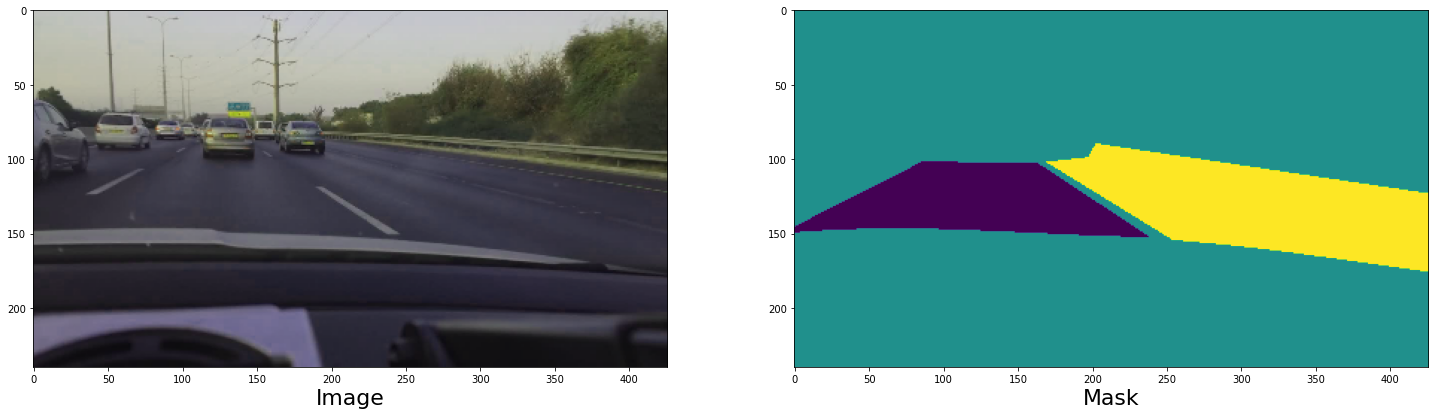

In [5]:
imgs = next(iter(train_loader))

image = convert_image(imgs[0][0])
mask = convert_mask(imgs[1][0])

_, ax = plt.subplots(1, 2, figsize=(25, 15))
ax[0].imshow(image)
ax[0].set_xlabel('Image', size=22)
ax[1].imshow(mask)
ax[1].set_xlabel('Mask', size=22);

#### Convert the Categoral Mask back to an RGB Image

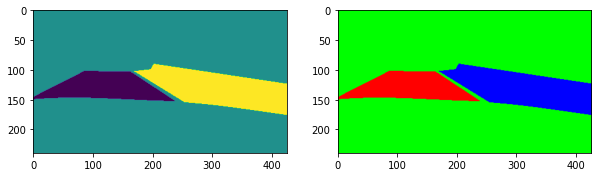

In [6]:
# convert the categoral image back to an RGB color mask
mask_out = cat2mask(mask) 

_, ax = plt.subplots(1, 2, figsize=(10, 8))
ax[0].imshow(mask)
ax[1].imshow(mask_out);

### Overlay the mask on the image
Create the image that we want the model to ultimatley produce: The mask overlaid on the image

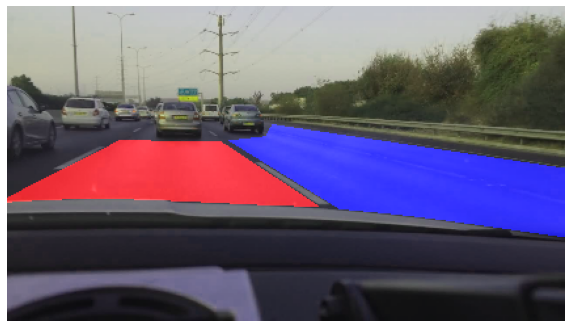

In [7]:
import cv2

# remove background for display
mask_out[:, :, 1] = 1

# need to use opencv to get color masks

def mask_image(image, mask):
    masked = cv2.addWeighted(image, 1, mask, 0.75, 0.)
    return masked

masked = mask_image(image, mask_out)
fig = plt.figure(figsize=(10, 8))
plt.imshow(masked);
plt.axis('off');

# <a name="Model"></a>2. Create A Deep Learning Model


## Model Definition

Here we will implement a [UNet](https://arxiv.org/pdf/1505.04597.pdf)

Other options could be:

*   [SegNet](https://arxiv.org/pdf/1511.00561.pdf)
*   [FCN](https://arxiv.org/pdf/1411.4038.pdf)
*   [DeepLab](https://arxiv.org/pdf/1606.00915.pdf)





In [8]:
from unet import Unet


#### Run a test to see if network was created properly
(This is also an easy way to confirm the shape of the model output)

In [9]:
# check for gpu
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [10]:
torch.cuda.empty_cache()
torch.cuda.memory_reserved()

0

Define model, optimizer, loss function, and other hyper parameters here

In [11]:
model = Unet(num_classes=3)

#### Define Loss Criterion

In [12]:
def dice_loss(pred, target, smooth=1.):

    pflat = pred.view(-1)
    tflat = target.view(-1)
    intersection = (pflat * tflat).sum()
    
    dice_loss = 1 - ((2. * intersection + smooth) 
                     / (pflat.sum() + tflat.sum() + smooth))

    return dice_loss

def loss_criterion(pred, target, w1=0.5, w2=0.5):
    dice = dice_loss(pred, target, smooth=1.)
    cross_entropy = nn.CrossEntropyLoss()(pred, target)

    loss =  w1*cross_entropy + w2*(1 - dice)
    # loss =  cross_entropy + torch.ln(dice)

    return loss

In [15]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

LEARNING_RATE = 0.0001
EPOCHS = 25

# defined by model but explicitly stated here
MODEL_OUTPUT_SIZE = (52, 228) 

criterion = nn.CrossEntropyLoss()
# criterion = loss_criterion
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

## MODEL TRAINING

In [16]:
# load model if needed
model = torch.load(r'models\25.pth').to(device)

In [16]:
import time 

# place model on device
model = model.to(device)

# store losses in lists
train_epoch_loss = []
valid_epoch_loss = []

for e in range(1, EPOCHS + 1):
    # train the model
    model.train()
    train_loss = []
    for i, (images, masks) in enumerate(train_loader):

        # move data to device
        images, masks = images.to(device), masks.to(device)

        # resize masks to match the network output
        masks = F.interpolate(masks.unsqueeze(1), MODEL_OUTPUT_SIZE)

        # forward pass through model and get loss
        outputs = model(images)

        loss = criterion(outputs.view(BATCH_SIZE, 3, -1), 
                         masks.view(BATCH_SIZE, -1).to(torch.long)) 

        # reset optimizer 
        optimizer.zero_grad()

        # backpropagate the loss
        loss.backward()

        # update the weights
        optimizer.step()

        # update the loss
        train_loss.append(loss.item())
        # display the loss every 100 mini-batches
        if i % 99 == 0:
            print(f'Epoch: {e} -- Train Loss: {train_loss[-1]:.3f}')
            time.sleep(7) # cool down


    # validate the model
    model.eval()
    valid_loss = []
    with torch.no_grad():
        for i, (images, masks) in enumerate(valid_loader):

            # move data to device
            images, masks = images.to(device), masks.to(device)

            # resize masks to match the network output
            masks = F.interpolate(masks.unsqueeze(1), MODEL_OUTPUT_SIZE)

            # forward pass through model and get loss
            outputs = model(images)

            loss = criterion(outputs.view(BATCH_SIZE, 3, -1), 
                         masks.view(BATCH_SIZE, -1).to(torch.long))
            
            # update the loss
            valid_loss.append(loss.item())
            # display the loss every 100 mini-batches
            if i % 99 == 0:
                print(f'Epoch: {e} -- Valid Loss: {valid_loss[-1]:.3f}')
                time.sleep(7) # cool down

    # get average train and valid loss for each epoch
    train_epoch_loss.append(np.mean(train_loss))
    valid_epoch_loss.append(np.mean(valid_loss))

    # save model every  epoch
    # if (e > 1) and e % 5 == 0:
    save_path = f'models\{e}.pth'
    torch.save(model, save_path)
    time.sleep(10) # cool down


Epoch: 1 -- Train Loss: 1.178
Epoch: 1 -- Train Loss: 1.035
Epoch: 1 -- Train Loss: 0.918
Epoch: 1 -- Train Loss: 0.739
Epoch: 1 -- Valid Loss: 0.934
Epoch: 2 -- Train Loss: 0.733
Epoch: 2 -- Train Loss: 0.598
Epoch: 2 -- Train Loss: 0.758
Epoch: 2 -- Train Loss: 0.524
Epoch: 2 -- Valid Loss: 0.581
Epoch: 3 -- Train Loss: 0.595
Epoch: 3 -- Train Loss: 0.502
Epoch: 3 -- Train Loss: 0.548
Epoch: 3 -- Train Loss: 0.499
Epoch: 3 -- Valid Loss: 0.734
Epoch: 4 -- Train Loss: 0.379
Epoch: 4 -- Train Loss: 0.392
Epoch: 4 -- Train Loss: 0.393
Epoch: 4 -- Train Loss: 0.490
Epoch: 4 -- Valid Loss: 0.681
Epoch: 5 -- Train Loss: 0.376
Epoch: 5 -- Train Loss: 0.406
Epoch: 5 -- Train Loss: 0.402
Epoch: 5 -- Train Loss: 0.389
Epoch: 5 -- Valid Loss: 0.593
Epoch: 6 -- Train Loss: 0.307
Epoch: 6 -- Train Loss: 0.354
Epoch: 6 -- Train Loss: 0.340
Epoch: 6 -- Train Loss: 0.684
Epoch: 6 -- Valid Loss: 0.739
Epoch: 7 -- Train Loss: 0.404
Epoch: 7 -- Train Loss: 0.319
Epoch: 7 -- Train Loss: 0.301
Epoch: 7 -

**Plot Training Results**

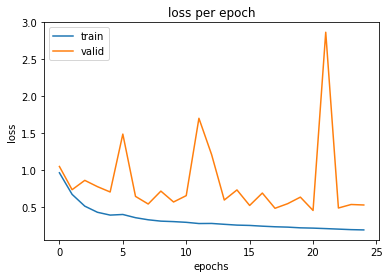

In [17]:
plt.plot(train_epoch_loss, label='train')
plt.plot(valid_epoch_loss, label='valid')
plt.title('loss per epoch')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

## Test the Model

In [18]:
# run test loop
model.eval()
test_loss = []
with torch.no_grad():
    for i, (images, masks) in enumerate(test_loader):

        # move data to device
        images, masks = images.to(device), masks.to(device)

        # resize masks to match the network output
        masks = F.interpolate(masks.unsqueeze(1), MODEL_OUTPUT_SIZE)

        # forward pass through model and get loss
        outputs = model(images)

        loss = criterion(outputs.view(BATCH_SIZE, 3, -1), 
                        masks.view(BATCH_SIZE, -1).to(torch.long))
        
        # update the loss
        test_loss.append(loss.item())
        # display the loss every 100 mini-batches
        if i % 99 == 0:
            print(f'Test Loss: {test_loss[-1]:.3f}')

Test Loss: 0.202


In [21]:
np.mean(test_loss)

0.5417739216770444

#### Display outputs from the test data

In [149]:
# load model if needed
# model = torch.load(r'models\10.pth').to(device)

In [20]:
# do a sample pass on some data!
images, masks = next(iter(test_loader))

# move to device
images, masks = images.to(device), masks.to(device)
model = model.to(device)

# run a forward pass to test things out
outputs = model(images)

In [21]:
# helper functions
def get_prediction_labels(outputs):
    predictions = F.softmax(outputs, dim=1)
    pred_labels = torch.argmax(predictions, dim=1) # each pixel has it's own label ID
    
    return pred_labels

def get_resized_mask(mask_cat, og_size=OG_SIZE):
    mask_cat = mask_cat.detach().cpu().numpy()
    mask = cv2.resize(cat2mask(mask_cat), og_size[::-1])

    return mask

In [22]:
# test helper functions and get prediction for a given test image
idx = 2

pred_labels = get_prediction_labels(outputs)
mask = get_resized_mask(masks[idx])
pred = get_resized_mask(pred_labels[idx])

img = cv2.resize(convert_image(images[idx]), OG_SIZE[::-1])

# remove background and mask image
pred_copy = pred.copy()
pred_copy[:, :, 1] = 0
pred_masked = mask_image(img, pred_copy)

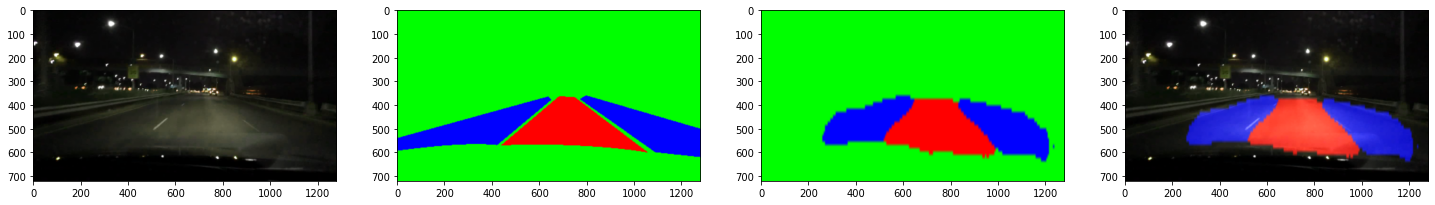

In [23]:
_, ax = plt.subplots(1, 4, figsize=(25, 10))
ax[0].imshow(img)
ax[1].imshow(mask)
ax[2].imshow(pred)
ax[3].imshow(pred_masked);

## Build Drivable Road segmentation pipeline

In [24]:
def get_drivable_area_mask(image, transform, model):
    # get original image shape
    og_size = image.shape[:2]

    # transform image and place on device
    image = test_transforms(image).unsqueeze(0).to(device)
    model = model.to(device)

    # get model outputs
    output = model(image)

    # get prediction labels
    pred_labels = get_prediction_labels(output)

    # get resized prediction mask
    pred_mask = get_resized_mask(pred_labels.squeeze(0), og_size)

    # remove green background for display
    pred_mask[:, :, 1] = 0

    return pred_mask

def segment_drivable_area(image):
    pred_mask = get_drivable_area_mask(image, test_transforms, model)
    segmented = mask_image(image, pred_mask)
    
    return segmented

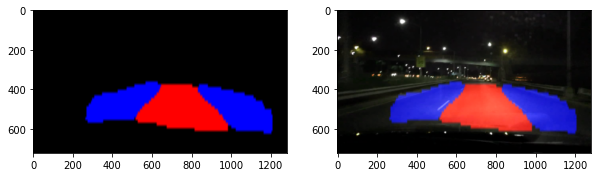

In [25]:
# test pipeline
pred_mask = get_drivable_area_mask(img, test_transforms, model)
segmented = segment_drivable_area(img)

_, ax = plt.subplots(1, 2, figsize=(10, 8))
ax[0].imshow(pred_mask)
ax[1].imshow(segmented);

### Test on out of sample data 
In this case out of sample data is anything road scenario that did not come from the bdd100k dataset. Eventhough this dataset is diverse, we only had 3000 images to train, validate, and test with. This out of sample testing will give us a good idea of just how well the model can generalize.

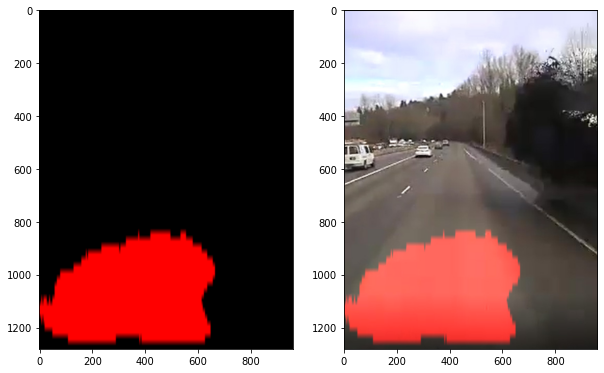

In [32]:
model = torch.load(r'models\20.pth').to(device)

image_path = r'..\segmentation_dataset\out_of_sample\highway.jpg'
image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)

pred_mask = get_drivable_area_mask(image, test_transforms, model)
segmented = segment_drivable_area(image)

_, ax = plt.subplots(1, 2, figsize=(10, 8))
ax[0].imshow(pred_mask)
ax[1].imshow(segmented);


# <a name="Video"></a>3. Run on a Video

Here is the best part. FCN models generally are fast. They can run on CPU at 5 FPS and on GPU at a very high frame rate.<p>
Test your code on a video and see how it worked.

In [40]:
video_path = r'..\segmentation_dataset\out_of_sample\videos\paris_challenge_Trim.mp4'

video_frames = []

cap = cv2.VideoCapture(video_path)

while(cap.isOpened()):

    ret, frame = cap.read()

    if ret == True:

        # get frames from the video in RGB
        video_frames.append(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

        # exit if needed
        # if cv2.waitKey(1) == ord('q'):
        #    break

    else:
        break

cap.release()
# cv2.DestroyAllWindows
del cap

#### Segment images

In [41]:
from tqdm import tqdm

model = torch.load(r'models\25.pth').to(device)
segmented_images = []

for image in tqdm(video_frames):
    segmented = segment_drivable_area(image)
    segmented_images.append(segmented)


100%|██████████| 452/452 [01:37<00:00,  4.64it/s]


In [42]:
len(segmented_images)

452

#### The model seems to struggle with shadows
In project.avi the model seems to have much trouble with shadows. A good modification to the data would be to augment shadows across the roads

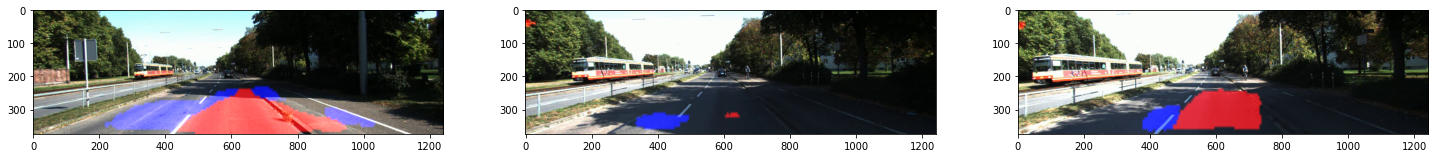

In [218]:
_, ax = plt.subplots(1, 3, figsize=(25, 25))
ax[0].imshow(segmented_images[92])
ax[1].imshow(segmented_images[98])
ax[2].imshow(segmented_images[100]);

In [43]:
# save as a video
VIDEO_PATH = r'..\segmentation_dataset\out_of_sample\videos\paris_challenge_Trim_segmented_25.mp4'

height, width = image.shape[:2] # ensure image comes from desired video
height, width = height//2, width//2
video = cv2.VideoWriter(VIDEO_PATH, cv2.VideoWriter_fourcc(*'DIVX'), 
                        60, (width, height))

for seg_img in segmented_images:
    # convert back to BGR for opencv
    seg_img = cv2.cvtColor(seg_img, cv2.COLOR_RGB2BGR)
    video.write(cv2.resize(seg_img, (width, height), 
                           cv2.INTER_LANCZOS4))

# cv2.destroyAllWindows()
video.release()
del video

**Costa Rica Challenge**<p>
Try your algorithm on Costa Rica roads!
Use the files **costa_rica_challenge** and **costa_rica_challenge_2** provided.<P>
/!\ video was taken from an iPhone X at 60 FPS and 4K resolution...